# Performance testing

On September 16, 2019, an experiment was conducted to determine the positioning accuracy and the maximum operating distance of our system. This in situ test was carried out in the Mediterranean Sea, about 10 kilometers south of Bastia, in Corsica (Figure 6). Three tracking devices have been installed on site to form an equilateral triangle with sides of about 300 meters, according to the procedure previously described. This distance represents the distance at which approximately 75% of the signals are detected by our hydrophones. GPS positions transmitted by the devices indicated an average distance of 270 meters between devices (Figure 6), a conservative value that is unlikely to negatively impact positioning accuracy.

A towed positioning test was carried out by attaching two transmitters to a weighted line that was hung on one side of the boat keeping the transmitters at depth between 13 and 16 meters. The boat slowly drifted within the array at a mean speed of 5 knots (Figure 7) in two steps. The first step consisted in randomly moving from waypoints yellow to red in order to evaluate the accuracy of the positioning system within the array. The second step consisted in moving from the red waypoint to the black waypoint in order to determine the maximum distance at which it was possible to calculate a position outside of the mesh. The position of the boat tracks during the towed test was recorded using a regular portable GPS (Garmin GPS73, accuracy: ± 3–5 m). These reference positions of the boat were then compared to those inferred from our positioning system. Maximum operational distance of the system was defined as the distance at which 33% or more of the positions can be inferred.

## Dependencies

In [40]:
# | STANDARD LIBRARY
from datetime import timedelta

# | CUSTOM LIBRARY
from functions import from_gpx, build_map, remove_intervals
from functions import space_method, time_method, space_time_method
from functions import Location

# | THIRD-PARTY LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium import PolyLine

## Import

Décrire les jeux de données et transférer toutes les fonctions dans un fichier apart

In [2]:
buoys_df = pd.read_csv("../../datasets/2019_09_16/buoys.csv")
pinger_df = pd.read_csv("../../datasets/2019_09_16/pinger.csv", index_col=2)
boat_df = from_gpx("../../datasets/2019_09_16/boat.gpx", index="datetime")

## Data exploration

Here we begin the data exploration process and immediately highlight a non-homogeneous dating process between the boat GPS and the GPS of the acoustic receiver. One hypothesis is that the boat's GPS does not take into account the locality and the summer time applied in France between March and November. We need to shift the datetime include in the `boat_df` `DataFrame` by +2 hours. We also need to remove the first entry in the `pinger_df` `DataFrame` because it has no reference point to compare with since the first boat location appears approximatly 30 seconds later.

In [3]:
boat_df.head()

,latitude,longitude,elevation
datetime,,,
2019-09-16 14:25:51+00:00,42.626092,9.489031,-4.7
2019-09-16 14:26:08+00:00,42.626137,9.489026,-8.0
2019-09-16 14:26:18+00:00,42.626183,9.489045,-8.3
2019-09-16 14:26:29+00:00,42.626229,9.489019,-6.9
2019-09-16 14:26:41+00:00,42.626278,9.489014,-6.1


In [4]:
pinger_df.head()

,latitude,longitude
datetime,,
2019-09-16 16:25:28,42.626055,9.489102
2019-09-16 16:26:22,42.626252,9.489045
2019-09-16 16:27:52,42.626101,9.488869
2019-09-16 16:27:56,42.626144,9.488942
2019-09-16 16:28:06,42.626163,9.488940


Concernant les positions GPS, certaine partie du parcours du bateau sont manquantes. Seules 11 positions ont été mesurées entre 16:38:20 et 16:42:18, le GPS a subit une défaillance, ce qui implique que cette portion n'est pas exploitable dans notre analyse. Cela nous oblige à retirer 13 points de données associés au pinger. Aucune données GPS n'a été collectées entre 16:48:58 et 16:50:56, certainement une autre défaillance du GPS. Aussi les points compris entre les heures 16:50:56 et 16:54:04 correspondent à une période de transition entre les phases de tests et ne doivent pas être pris en compte. Cela represénte 11 autres point de données associés au pinger qui devront être supprimés. Enfin, 7 autres points de données ne seront pas considérés car une dernière portion est manquante entre 16:57:41 et 16:58:15.

In [5]:
boat_map_options = {
    'color': 'black', 
    'fill_color': "orange", 
    'weight': 1, 
    'fill': True, 
    'fill_opacity': 1, 
    'radius':4
}

build_map(
    boat_df, 
    (buoys_df.iloc[0, 1], buoys_df.iloc[0, 2]),
    boat_df,
    buoys_df,
    True,
    boat_map_options,
    zoom_start=17, 
    zoom_control=True
    )

In [6]:
boat_df.loc[(boat_df.index >= '2019-09-16 14:38:20') & (boat_df.index <= '2019-09-16 14:42:18')].count()

latitude     11
longitude    11
elevation    11
dtype: int64

In [36]:
boat_map_options = {
    'color': 'black', 
    'fill_color': "purple", 
    'weight': 1, 
    'fill': True, 
    'fill_opacity': 1, 
    'radius':4
}

map = build_map(
    pinger_df, 
    (buoys_df.iloc[0, 1], buoys_df.iloc[0, 2]),
    boat_df,
    buoys_df,
    True,
    boat_map_options,
    zoom_start=17, 
    zoom_control=True
    )

PolyLine(locations=[
    [buoys_df.iloc[0].latitude, buoys_df.iloc[0].longitude],
    [buoys_df.iloc[1].latitude, buoys_df.iloc[1].longitude],
    [buoys_df.iloc[2].latitude, buoys_df.iloc[2].longitude],
    [buoys_df.iloc[0].latitude, buoys_df.iloc[0].longitude]],
    color='black', opacity=1.0).add_to(map)

map

In [59]:
outside_points = [
    '2019-09-16 16:26:22+00:00', 
    '2019-09-16 16:27:52+00:00', 
    '2019-09-16 16:28:06+00:00', 
    '2019-09-16 16:54:12+00:00', 
    '2019-09-16 16:55:40+00:00',
    '2019-09-16 16:55:52+00:00',
    '2019-09-16 16:56:02+00:00',
    '2019-09-16 16:56:18+00:00',
    '2019-09-16 16:56:40+00:00']
    
outside_beyond = '2019-09-16 17:00:15+00:00'

In [8]:
time_intervals = [
    ('2019-09-16 16:38:20', '2019-09-16 16:42:18'),
    ('2019-09-16 16:48:58', '2019-09-16 16:54:04'),
    ('2019-09-16 16:57:41', '2019-09-16 16:58:15')
    ]

sum([pinger_df.loc[(pinger_df.index >= start) & (pinger_df.index < end)].count() for start, end in time_intervals])

latitude     31
longitude    31
dtype: int64

## Data cleaning

Comme nous l'avons vu durant notre exploration des données, il est nécessaire de :
1. harmoniser la datation entre les jeux de données
2. supprimer la première entrée des données de positions du pinger
3. supprimer les données de positions du pinger pour 3 différents intervalles de temps

In [9]:
boat_df.index = boat_df.index.tz_convert('UTC')
boat_df.index = boat_df.index.map(lambda datetime: datetime + timedelta(hours=2))
pinger_df.index = pd.to_datetime(pinger_df.index, utc=True)

In [10]:
pinger_df = pinger_df.drop(labels=[pinger_df.iloc[0].name])
pinger_df = remove_intervals(pinger_df, time_intervals)

## Performance analysis

Afin d'analyser les performances de notre système, il est nécessaire dans un premier temps d'associer à chaque position de l'émetteur acoustique la bonne position GPS afin que le calcule de précision soit pertinent. Parce que l'émetteur et le GPS ne sont pas synchronisés, nous utiliserons trois méthodes basées sur l'écart spatial, l'écart temporel et l'écart spatial et temporel, respectivement. Nous comparerons alors les résultats obtenus.

Aussi, chacun des écarts de position obtenu sera calculé en fonction de sa distance à la position moyenne des trois récepteurs acoustiques `mean_buoys_location`.

In [11]:
mean_buoys_location = Location(buoys_df["latitude"].mean(), buoys_df["longitude"].mean())

La première méthode recherche pour chaque point GPS du pinger le point GPS du bateau le plus proche dans l'espace dans un interval de temps convenable ici fixé à ± 15 secondes. La deuxième méthode recherche les points les plus rapprochés dans le temps. Enfin, la troisième méthode se base à la fois sur la différence spatiale (en abscisse) et temporelle (en ordonnée), prenant le point dont la distance euclidienne est la plus faible.

In [12]:
dt = 15
space_df = space_method(pinger_df, boat_df, mean_buoys_location, dt)
time_df = time_method(pinger_df, boat_df, mean_buoys_location, dt)
space_time_df = space_time_method(pinger_df, boat_df, mean_buoys_location, dt)
all_df = pd.concat([space_df, time_df, space_time_df])

Sans surprise, la méthode n°1 donne en moyenne à notre système la meilleur précision (6.21 m) au prix de la différence temporelle moyenne la élevée (7.06 s). La méthode n°2 offre la moins bonne précision (8.89 m) au bénéfice de la différence temporelle moyenne la plus faible (2.78 s). Enfin, la troisième méthode se trouve être un compromis entre les deux précédentes méthodes avec une précision moyenne de 7.13 mètres pour une différence temporelle moyenne de 4.44 seconds.

<AxesSubplot:xlabel='method', ylabel='time_diff'>

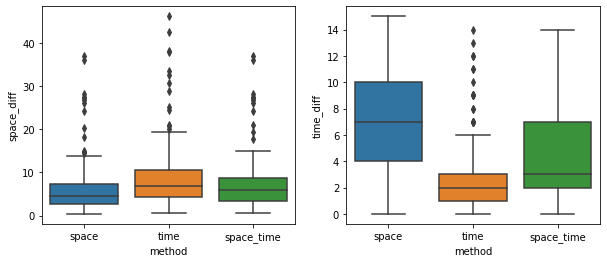

In [28]:
fig, axs = plt.subplots(figsize=(10, 4), ncols=2)
sns.boxplot(x="method", y="space_diff", data=all_df, ax=axs[0])
sns.boxplot(x="method", y="time_diff", data=all_df, ax=axs[1])

<AxesSubplot:xlabel='distance', ylabel='space_diff'>

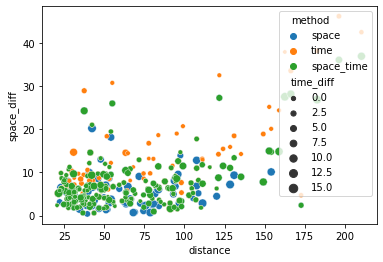

In [25]:
sns.scatterplot(x="distance", y="space_diff", size="time_diff", hue="method", data=all_df)

In [61]:
space_time_df.loc[outside_points]

KeyError: "['2019-09-16 16:26:22+00:00', '2019-09-16 16:27:52+00:00', '2019-09-16 16:28:06+00:00', '2019-09-16 16:54:12+00:00', '2019-09-16 16:55:40+00:00', '2019-09-16 16:55:52+00:00', '2019-09-16 16:56:02+00:00', '2019-09-16 16:56:18+00:00', '2019-09-16 16:56:40+00:00'] not in index"

In [57]:
outside_points

['2019-09-16 16:26:22',
 '2019-09-16 16:27:52',
 '2019-09-16 16:28:06',
 '2019-09-16 16:54:12',
 '2019-09-16 16:55:40',
 '2019-09-16 16:55:52',
 '2019-09-16 16:56:02',
 '2019-09-16 16:56:18',
 '2019-09-16 16:56:40',
 Timestamp('2019-09-16 17:00:15+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:19+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:25+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:29+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:31+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:37+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:41+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:43+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:45+0000', tz='UTC'),
 Timestamp('2019-09-16 17:00:59+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:05+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:11+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:17+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:19+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:21+0000', tz='UTC'),
 Timestamp('2019-09-16 17:01:51+00